In [96]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal
from scipy.interpolate import interp1d
from IPython.display import Audio

In [183]:
def decimation_signal(signal_in, N_decimate):
    return signal_in[::N_decimate]


def stretch_signal(signal_in, N_stretch):
    return np.array([signal_in[i//N_stretch] if i%N_stretch == 0 else 0
                     for i in range(len(signal_in) * N_stretch)])


def beta_kaiser(A):
    '''Función por tramos que indica el valor que debe tomar el
    parámetro beta
    
    Parámetros
    - A: Ganancia máxima entre ripple de pasa banda y rechaza 
         banda obtenido anteriormente mediante la parametrización
         
    Referencias
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    '''
    if A < 21:
        return 0
    elif 21 <= A <= 50:
        return 0.5842 * (A - 21) ** 0.4 + 0.07886 * (A - 21)
    else:
        return 0.1102 * (A - 8.7)


def lowpass_filter(signal_in, samplerate, freq_pass, freq_stop,
                   method='fir', fir_method='kaiser', gpass=1, 
                   gstop=80, plot_filter=False, correct_by_gd=True,
                   gd_padding='periodic', normalize=True):
    '''Función que permite crear un filtro pasabajos con una frecuencia
    de corte ingresada por el usuariom el cual se aplicará a la señal de
    entrada de la función.
    
    Parámetros
    - signal: Señal a filtrar
    - samplerate: Tasa de muestreo de la señal utilizada
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda
    - cutoff_freq: Frecuencia de corte en radianes (pi representa fs/2)
    - method: Método de filtrado
        - ['fir']: Se implementa mediante un filtro fir
        - ['iir']: Se implementa mediante un filtro iir
        - ['cut']: Se implementa simplemente cortando en la frecuencia de interés
    - fir_method: Método de construcción del filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - plot_filter: Booleano que permite graficar la señal a ifiltrar y el filtro
    - correct_by_gd: Booleano que permite corregir la salida del filtro FIR por su
                     retraso de grupo
    - gd_padding: Formato para el padding de la señal de entrada
        - [None]: No se hace padding
        - ['zero']: Se hace padding con "len(signal_in)" ceros a la izquierda y
                    derecha de la señal
        - ['periodic']: Se hace padding copiando la señal 3 veces
        - ['constant']: Se hace padding copiando el primer y el último valor para
                        el caso de la izquierda y la derecha respectivamente
    - normalize: Normalización de la señal de salida
    '''
    # Obtención de los parámetros para cada método
    if method == 'fir':
        num = fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=gpass,
                                 gstop=gstop, use_exact=True, method=fir_method,
                                 print_window=plot_filter, apply_firwin=False)
        den = 1
    elif method == 'iir':
        num, den = signal.iirdesign(wp=freq_pass / samplerate,
                                    ws=freq_stop / samplerate,
                                    gpass=gpass, gstop=gstop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
    elif method == 'cut':
        gd = 0 
        signal_filtered =  lowpass_cut_frequency(signal_in, samplerate, 
                                                 freq_stop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
    
    # Presentación de la señal de entrada
    if gd_padding is None:
        signal_to_filt = signal_in
    elif gd_padding == 'zero':
        signal_to_filt = np.concatenate(([0] * len(signal_in),
                                         signal_in,
                                         [0] * len(signal_in)))
    elif gd_padding == 'periodic':
        signal_to_filt = np.concatenate((signal_in,
                                         signal_in,
                                         signal_in))
    elif gd_padding == 'constant':
        signal_to_filt = np.concatenate(([signal_in[0]] * len(signal_in),
                                         signal_in,
                                         [signal_in[-1]] * len(signal_in)))
    else:
        raise Exception('Opción de padding no disponible. Por favor, intente '
                        'nuevamente')
    
    # Para poder filtrar el audio
    if method != 'cut':
        _, gd = signal.group_delay((num, den))
        signal_filtered = signal.lfilter(num, den, signal_to_filt)
        
        # Si se hace padding, se debe cortar de tal forma que se logre sincro-
        # nizar la señal de entrada en función del delay de grupo
        if gd_padding is not None:
            # Delay de grupo aproximado
            delay = round(np.mean(gd))
            
            # Definición de los índices a considerar. Se escogen estos índices
            # ya que se asume que el comportamiento ideal de la señal 3 veces
            # paddeada, se encuentra en el centro del arreglo
            ini_index = int(len(signal_in) + delay)
            end_index = int(2 * len(signal_in) + delay)
            
            # Recortando
            signal_filtered = signal_filtered[ini_index:end_index]
    
    if plot_filter:        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots(2,1)
        
        # Graficando la señal
        ax[0].set_title('')
        ax[0].plot(signal_to_filt)
        
        # Y obteniendo la función de transferencia h
        w, h = signal.freqz(num, den)
        # Graficando el filtro
        ax[1].set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax[1].plot(w, magnitude, 'r')
        ax[1].set_ylabel('Magnitude [dB]', color='r')
        ax[1].set_xlabel('Frequencia [rad/sample]')
        ax[1].set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax[1].twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return gd, signal_filtered / max(abs(signal_filtered))
    else:
        return gd, signal_filtered


def lowpass_cut_frequency(signal_in, samplerate, freq_stop,
                          signal_ref=None):
    '''Función de filtro pasa bajos que corta en una frecuencia 
    determinada, simplemente haciendo cero las frecuencias más
    altas que la frecuencia de corte.
    
    Parámetros
    - signal_in: Señal de entrada
    - samplerate: Frecuencia de muestreo de la señal
    - freq_stop: Frecuencia de corte de la señal
    - signal_ref: Señal de referencia (se utiliza en caso de que 
                  se busque que la señal de salida sea de un largo
                  distinto al de la señal de entrada, por ejemplo,
                  en un proceso de upsampling)
    '''
    # Condición de inicio
    if signal_ref is None:
        signal_ref = signal_in
    
    # Frecuencia de corte relativa
    w_cut =  freq_stop / samplerate
    # Punto de la frecuencia de corte
    cutpoint = int(w_cut * len(signal_ref))

    # Calculando su transformada de Fourier
    signal_fft = np.fft.fft(signal_in)
    # Componentes de la FFT
    mag = np.abs(signal_fft)
    pha = np.angle(signal_fft)

    # Realización del corte en la frecuencia definida
    mag_cutted = np.concatenate((mag[:cutpoint], 
                                 [0] * (len(signal_in) - cutpoint * 2),
                                 mag[-cutpoint:]))

    # Reconstruyendo la señal
    signal_cutted = mag_cutted * np.exp(1j * pha)

    # Aplicando la trnasformada inversa
    signal_lp = np.real(np.fft.ifft(signal_cutted))
    
    return signal_lp


def fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=1,
                       gstop=50, use_exact=True, print_window=True,
                       method='window', parity='odd', 
                       apply_firwin=False):
    '''Diseño de filtros FIR mediante el método de ventaneo. Esta 
    función retorna los coeficientes h[n] del filtro en el tiempo.
    Este filtro minimiza el orden del filtro seleccionando la 
    ventana más conveniente en base a la declaración en decibeles
    de la ganancia de la rechaza banda.
    
    Parámetros
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda
    - samplerate: Tasa de muestreo de la señal utilizada
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - use_exact: Booleano que indica si se usa el valor exacto de 
                 transición entre bandas (delta omega)
    - print_window: Booleano que indica si se imprime la ventana
                    seleccionada y su orden
    - method: Método de construcción del filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    
    Referencias:
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    [2] Página CCRMA de Julius O. Smith III, disponible en:
        https://ccrma.stanford.edu/~jos/
    '''
    # Definición de los ripples en escala absoluta [1]
    delta_p = (10**(gpass/20) - 1)/(10**(gpass/20) + 1)
    delta_s = (1 + delta_p)/(10**(gstop/20))
    # Se escoge el mínimo delta para el diseño de la
    # ganancia A [1]
    delta = min(delta_p, delta_s)
    
    # Definición de ganancia límite
    A = -20*np.log10(delta) 
    
    # Definición de la frecuencia de corte
    cutoff_freq = (freq_pass + freq_stop) / 2
    # Definición de la frecuencia central angular
    omega_c = 2 * np.pi * cutoff_freq / samplerate
    
    # Definición del ancho de banda delta omega 
    trans_width = abs(freq_pass - freq_stop)
    # Definición del ancho de banda delta omega angular
    band_w = 2 * np.pi * trans_width / samplerate
    
    # Para el procedimiento del filtro FIR mediante ventaneo
    if method == 'window':
        # Definición de las ventanas
        windows = (('rectangular', 21, 4 * np.pi, 1.8 * np.pi),
                   ('bartlett', 26, 8 * np.pi, 6.1 * np.pi),
                   ('hann', 44, 8 * np.pi, 6.2 * np.pi),
                   ('hamming', 53, 8 * np.pi, 6.6 * np.pi),
                   ('blackman', 71, 12 * np.pi, 11 * np.pi))

        # Selección de la ventana
        index_window = np.argmin([abs(i[1] - A) for i in windows])

        # Definición de la ventana elegida
        window_choose = windows[index_window][0]
        
        # Una vez seleccionada la ventana, se escoge el orden del filtro,
        # procurando que el ancho del lóbulo principal no sea más grande
        # que la frecuencia de corte [1][2]
        delta_w = 3 if use_exact else 2
        L = round(windows[index_window][delta_w] / band_w)

        # Definición del orden del polinomio de la función de trans-
        # ferencia (largo del filtro). Mientras que L es el largo de
        # la respuesta al impulso
        M = L - 1
        
    # Para el procedimiento mediante ventana kaiser
    elif method == 'kaiser':
        # Definición de la ventana elegida
        window_choose = 'kaiser' 
        
        # Cálculo del beta
        beta = beta_kaiser(A)
        
        # Estimación del orden del filtro [1]
        M = int(np.ceil((A - 8) / (2.285 * band_w)))  
    # Para el procedimiento mediante algoritmo remez
    elif method == 'remez':
        # El orden del filtro está dado por la relación empírica 
        # propuesta por Kaiser
        M = (-20*np.log10(np.sqrt(delta_s*delta_p)) - 13)/(2.324*band_w)
        # Definición del parámetro de construcción de la ventana
        K = delta_p/delta_s
        
        # Especificación del filtro
        M = int(np.ceil(M))
        M = M  if M % 2 == 0 else M + 1
        
        # Se define el set de frecuencias crítico para el algotitmo
        # el cual contiene [0, wp, ws, pi], donde todas son divididas
        # en 2*pi (se expresan en "f").
        fo = [0, freq_pass, freq_stop, samplerate/2]
        
        
        # Este vector contiene los valores que tomarán las amplitudes de
        # las frecuencias de interés definidas anteriormente (cada una 
        # representa un rango, por ejemplo entre 0 y freq_pass -> 1  
        # y entre  freq_stop y samplerate/2 -> 0)
        ao = [1, 0]
        
        # Corresponde a los valores que toma la función W(omega) para 
        # cada banda
        W = [1, K]
        
        # Aplicando entonces Parks-McClellan
        return signal.remez(M + 1, fo, ao, W, fs=samplerate)
    
    # Si es que M es impar, mantenerlo impar, si es que es par, 
    # sumar 1
    M = M  if M % 2 == 0 else M + 1
    # Redefiniendo L
    L = M + 1
    
    if print_window:
        print(f'Ventana: {window_choose}\n'
              f'Largo resp. al impulso: {L}')
    
    # Aplicando el filtro
    if apply_firwin:
        if window_choose == 'kaiser':
            window_choose = ('kaiser', beta)
            
        return signal.firwin(L, cutoff_freq, 
                             window=window_choose,
                             fs=samplerate)
    else:
        # Selección de ventana
        if window_choose == 'rectangular':
            window = np.ones(L)
        elif window_choose == 'bartlett':
            window = np.bartlett(L)
        elif window_choose == 'hann':
            window = np.hanning(L)
        elif window_choose == 'hamming':
            window = np.hamming(L)
        elif window_choose == 'blackman':
            window = np.blackman(L)
        elif window_choose == 'kaiser':
            window = np.kaiser(L, beta)
        
        # Definición de la respuesta al impulso del filtro pasabajo 
        # ideal
        hd = lambda n: (np.sin(omega_c*(n - M/2))/(np.pi*(n - M/2)))\
                        if (n != M/2) else omega_c/np.pi
        
        # Calculando
        hd_n = np.asarray([hd(i) for i in range(L)])
        return  hd_n * window


def downsampling_signal(signal_in, samplerate, freq_pass, freq_stop, 
                        method='lowpass', lp_method='fir',
                        resample_method='interp1d',
                        fir_method='kaiser', gpass=1, gstop=80,
                        correct_by_gd=True, gd_padding='periodic',
                        plot_filter=False, normalize=True):
    '''Función que permite disminuir la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la frecuencia
    de corte para el pasabajo. Es decir, dada una frecuencia de corte
    de interés, se resampleará la señal al doble de esa frecuencia.
    
    Parameters
    ----------
    signal_in : list or ndarray
        Señal a submuestrear.
    samplerate : int
        Tasa de muestreo de la señal "signal_in".
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    freq_stop : float
        Frecuencia de corte de la rechaza banda. Esta es la que se toma
        en cuenta al momento de hacer el último corte (por ende, si 
        busca samplear a 2kHz, seleccione este parámetro en 1kHz).
    method : {'lowpass', 'cut'}, optional
        Método utilizado para filtrar la señal. Para 'lowpass', se aplica un filtro pasabajos 
        para evitar aliasing de la señal, luego se submuestrea. Para 'cut', se corta en la 
        frecuencia de interés. Por defecto es 'lowpass'.
    lp_method : {'fir', 'iir'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Por defecto es 'fir'.
    resample_method : {'resample', 'resample poly', 'interp1d', 'decimation'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'decimation' se  realiza una 
        decimación a la señal por un parámetro "N_dec" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente.
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Referencias
    -----------
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula el paso de la decimación
    N_dec = round(samplerate / (freq_stop * 2))
    
    # Calculo de la nueva tasa de muestreo
    new_rate = 2 * freq_stop
    
    # Selección del método del pasabajos
    if method == 'lowpass':
        # Aplicando el filtro pasa bajos
        gp, signal_lp = lowpass_filter(signal_in, samplerate, freq_pass, 
                                       freq_stop, method=lp_method, 
                                       fir_method=fir_method, gpass=gpass, 
                                       gstop=gstop, plot_filter=plot_filter,
                                       correct_by_gd=correct_by_gd,
                                       gd_padding=gd_padding,
                                       normalize=normalize)
    elif method == 'cut':
        signal_lp = lowpass_cut_frequency(signal_in, samplerate, 
                                          freq_stop)
    else:
        raise Exception('Opción de método no válido. Por favor, ingrese'
                        ' un valor válido.')
    
    # Selección del método de resampleo
    if resample_method == 'resample':
        return new_rate, signal.resample(signal_lp, 
                                         len(signal_lp)//N_dec)
    
    elif resample_method == 'resample_poly':
        return new_rate, signal.resample_poly(signal_lp, 
                                              len(signal_lp)//N_dec, 1)
    
    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_lp))
        
        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_lp) - 1, len(signal_lp)//N_dec)
        
        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_lp)

        return new_rate, f(x_new)
    
    elif resample_method == 'decimation':
        # Calculo de la nueva tasa de muestreo
        new_rate = samplerate // N_dec
        
        return new_rate, decimation_signal(signal_lp, N_decimate=N_dec)


def upsampling_signal(signal_in, samplerate, new_samplerate,
                      N_desired=None, method='lowpass',
                      trans_width=50, lp_method='fir',
                      resample_method='interp1d',
                      fir_method='kaiser', gpass=1, gstop=80, 
                      correct_by_gd=True, gd_padding='periodic',
                      plot_filter=False, plot_signals=False,
                      normalize=True):
    '''Función que permite aumentar la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la nueva tasa
    de muestreo deseada.
    
    Parameters
    ----------
    signal_in : list or ndarray
        Señal a submuestrear.
    samplerate : int
        Tasa de muestreo de la señal "signal_in".
    new_samplerate : int
        Tasa de muestreo deseada de la señal.
    method : {'lowpass', 'cut'}, optional
        Método utilizado para filtrar la señal. Para 'lowpass', se aplica un filtro pasabajos 
        para evitar aliasing de la señal, luego se submuestrea. Para 'cut', se corta en la 
        frecuencia de interés. Por defecto es 'lowpass'.
    trans_width : int 
        Banda de transición entre la frecuencia de corte de la señal original (que representa 
        la frecuencia de corte del rechaza banda) y la pasa banda del filtro aplicado para 
        eliminar las repeticiones [1]
    lp_method : {'fir', 'iir'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Por defecto es 'fir'.
    resample_method : {'resample', 'resample poly', 'interp1d', 'stretching'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'stretching' se realiza el 
        estiramiento a la señal por un parámetro "N_st" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente.
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    plot_signals : bool
        Activar ploteo de la magnitud de las señales.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Referencias
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula la cantidad de puntos a añadir en stretch
    N_st = int(new_samplerate / samplerate)
    
    if resample_method == 'stretching':
        # Aplicando stretching
        signal_stretched = stretch_signal(signal_in, N_stretch=N_st)

        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            if len(signal_stretched) < N_desired: 
                signal_stretched = np.append(signal_stretched,
                                             [0] * (N_desired \
                                                    - len(signal_stretched)))
            else:
                signal_stretched = signal_stretched[:N_desired]


        if method == 'lowpass':
            # Definición de las bandas del filtro
            freq_stop = samplerate / 2
            freq_pass = freq_stop - trans_width

            # Aplicando el filtro
            _, signal_lp = lowpass_filter(signal_stretched, new_samplerate, 
                                          freq_pass, freq_stop, method=lp_method, 
                                          fir_method=fir_method, gpass=gpass, 
                                          gstop=gstop, correct_by_gd=correct_by_gd,
                                          gd_padding=gd_padding,
                                          plot_filter=plot_filter, 
                                          normalize=normalize)    
        elif method == 'cut':
            # Definición de la frecuencia de corte
            freq_stop = samplerate / 2
            # Método de corte
            signal_lp = lowpass_cut_frequency(signal_stretched, samplerate, 
                                              freq_stop, signal_ref=signal_in)
        
    elif resample_method == 'resample':
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / new_samplerate * samplerate)
        
        print(N_out)
        signal_out = signal.resample(signal_in, N_out)
    
    elif resample_method == 'resample_poly':
        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / new_samplerate * samplerate)
        
        # Señal resampleada
        signal_out = signal.resample_poly(signal_in, N_out, len(signal_in))
    
    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_in))
        
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / new_samplerate * samplerate)
        
        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_in) - 1, N_out)
        
        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_in)
        
        # Definición de la señal de salida
        signal_out = f(x_new)
    
    if plot_signals:
        plt.subplot(3,1,1)
        plt.plot(abs(np.fft.fft(signal_in)))
        plt.title('Magnitud señal de entrada')

        plt.subplot(3,1,2)
        plt.plot(abs(np.fft.fft(signal_stretched)))
        plt.title('Magnitud señal stretched')

        plt.subplot(3,1,3)
        plt.plot(abs(np.fft.fft(signal_lp)))
        plt.title('Magnitud señal salida')

        plt.show()
    
    if normalize:
        return signal_out / max(abs(signal_out))
    else:
        return signal_out
    
    
def resampling_by_points(signal_in, samplerate, N_desired, trans_width=50,
                         method='lowpass', lp_method='fir', fir_method='kaiser', 
                         gpass=1, gstop=80, correct_by_gd=True, gd_padding='periodic',
                         plot_filter=False, normalize=True):
    '''Función que resamplea una señal de entrada en función de la cantidad de puntos
    deseados de salida
    
    Parameters
    ----------
    signal_in : list, tuple or ndarray
        Señal de entrada a resamplear
    N_desired : int
        Cantidad de puntos deseada en la señal de salida
        
    Returns
    -------
    '''
    # En caso de que sea igual, se mantiene
    if N_desired == len(signal_in):
        return signal_in
    
    # En caso de que sea menor, se aplica "downsampling" (resampleo)
    elif N_desired < len(signal_in):
        # Definición de la frecuencia de corte para aplicación en la función
        freq_stop = N_desired * samplerate / (2 * len(signal_in))
        # Definición de la frecuencia final de pasabanda
        freq_pass = freq_stop - trans_width
        
        # Aplicando el filtro pasa bajos (anti aliasing)
        gp, signal_to_res = lowpass_filter(signal_in, samplerate, freq_pass, 
                                           freq_stop, method=lp_method, 
                                           fir_method=fir_method, 
                                           gpass=gpass, gstop=gstop, 
                                           plot_filter=plot_filter,
                                           correct_by_gd=correct_by_gd,
                                           gd_padding=gd_padding,
                                           normalize=normalize)
    
    # En caso de que sea mayor, se mantiene la señal normal
    elif N_desired > len(signal_in):
        # Solo se normaliza en caso de ser pertinente
        if normalize:
            signal_to_res = signal_in / max(abs(signal_in))
        else:    
            signal_to_res = signal_in
    
    # Y resampleando esta señal
    if method == 'resample':
        # Señal de salida
        signal_out = signal.resample(signal_to_res, N_desired)

    elif method == 'resample_poly':
        # Señal de salida
        signal_out = signal.resample_poly(signal_to_res, up=N_desired, 
                                          down=len(signal_in))

    elif method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_to_res))

        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_in) - 1, N_desired)

        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_to_res)

        # Señal de salida
        signal_out = f(x_new)

    else:
        raise Exception('Opción no válida para el método. Por favor, '
                        'intente nuevamente con una opción válida.')
    
    return signal_out

<IPython.core.display.Javascript object>


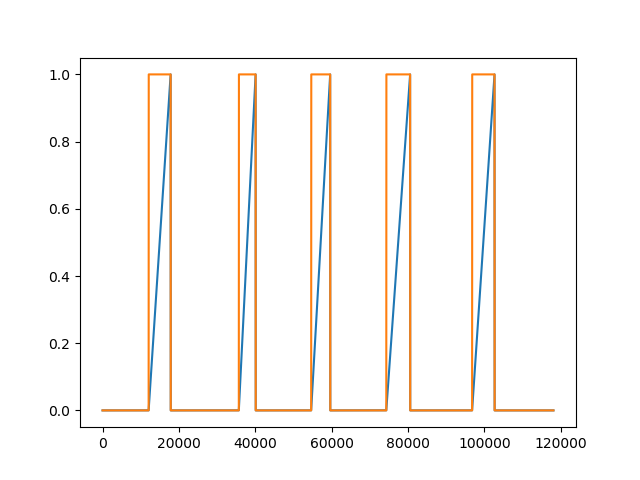

In [60]:
def create_visual_lookups(N_periods, lens_sig, lens_sil):
    '''Función que permite crear una representación temporal de las activaciones
    de las señales de interés
    
    Parameters
    ----------
    N_periods : int
        Cantidad de perídos de activación que tendrá la señal
    lens_sig : ndarray
        Arreglo de largos que tendrán las señales a replicar
    lens_sil : ndarray
        Arreglo de largos que tendrán los silencios a replicar
        
    Returns
    -------
    sawtooth_arr : ndarray
        Señal de diente de sierra de la activación de las señales
    square_arr : ndarray
        Señal cuadrada de la activación de las señales   
    '''
    # Definición del arreglo donde se almacenará la forma del diente de sierra
    sawtooth_arr = np.array([])
    # Definición del arreglo donde se almacenará la forma de la señal cuadrada
    square_arr = np.array([])
    
    for i in range(N_periods):
        # Creación del vector de valores cero
        zeros_to_append = np.zeros(lens_sil[i])
        
        # Creación del vector de diente de sierra a revisar
        sawtooth_to_append = np.linspace(0, 1, lens_sig[i])
        
        # Creación del vector cuadrado a revisar
        square_to_append = np.ones(lens_sig[i])
        
        # Agregando los valores generados
        sawtooth_arr = np.concatenate((sawtooth_arr, zeros_to_append, 
                                       sawtooth_to_append))
        square_arr = np.concatenate((square_arr, zeros_to_append, 
                                     square_to_append))
    
    
    # Agregando los ceros finales del diente de sierra y cuadrado 
    # respectivamente
    sawtooth_arr = np.concatenate((sawtooth_arr, np.zeros(lens_sil[-1])))
    square_arr = np.concatenate((square_arr, np.zeros(lens_sil[-1])))
    
    return sawtooth_arr, square_arr


def lookup_table_function(N_periods, params_signal, params_silence,
                          gen_type='normal', seed=0):
    '''Por definir
    
    Parameters
    ----------
    N_periods : int
        Cantidad de perídos de activación que tendrá la señal
    
    params_signal : list or tuple
        Parámetros que dependerán del formato de generación de números
        aleatorios elegido. Si es "normal", el índice 0 será mu y el 1
        será sigma. Si es "uniforme", el índice 0 será el mínimo valor
        del largo posible y el índice 1 será el máximo valor del largo
        posible.
    
    params_silence : list or tuple
        Sigue la misma lógica que params_signal, pero aplicado a los
        intervalos en los que habrá silencio.
    
    gen_type : {'normal', 'uniform'}, optional
        Método de generación de números aleatorios. Al escoger "normal"
        se crearán mediante un proceso de generación vía dist. normal 
        (0,1). Si se escoge "uniform", se crearán mediante un proceso
        de generación vía distribución uniforme.
        
    seed : int, optional
        Valor de la semilla a utilizar para el experimento. Por defecto 
        es 0
    
    Returns
    -------
    Por def
    '''
    # Plantando la semilla
    np.random.seed(seed)
    
    # Creación de los largos de cada intervalo
    if gen_type == 'normal':
        # Generación de números aleatorios
        rand_sig = np.random.randn(N_periods)
        rand_sil = np.random.randn(N_periods + 1)
        
        # Escalando y redoneando a la escala de interés
        lens_sig = np.rint(params_signal[1] * rand_sig + params_signal[0])
        lens_sil = np.rint(params_silence[1] * rand_sil + params_silence[0])
        
        # Pasando a valores enteros
        lens_sig = lens_sig.astype('int32')
        lens_sil = lens_sil.astype('int32')
        
    elif gen_type == 'uniform':
        # Generación de números aleatorios
        lens_sig = np.random.randint(low=params_signal[0],
                                     high=params_signal[1],
                                     size=N_periods)
        lens_sil = np.random.randint(low=params_silence[0],
                                     high=params_silence[1],
                                     size=N_periods + 1)
    
    else:
        raise Exception('Opción no válida para parámetro "gen_type". '
                        'Por favor, intente nuevamente con una opción'
                        ' válida.')
    
    # Creando las señales a rev
    sawtooth_arr, square_arr = create_visual_lookups(N_periods, lens_sig, lens_sil)
    
    
    
    plt.plot(sawtooth_arr)
    plt.plot(square_arr)
    plt.show()
    
%matplotlib notebook
lookup_table_function(5, (4000,1000), (15000,3000),
                      gen_type='normal', seed=0)

# Probando la función de resampling

<IPython.core.display.Javascript object>


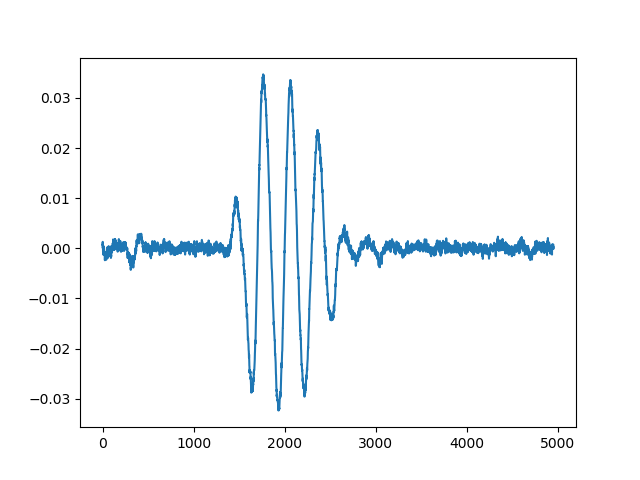

In [85]:
filename = '2-S2-normal__201101070538'
audio, samplerate = sf.read(f'db_heart/Heart_segments/{filename}.wav')
Audio(audio, rate=samplerate)

%matplotlib notebook
plt.plot(audio)
plt.show()

4955
60000


<IPython.core.display.Javascript object>


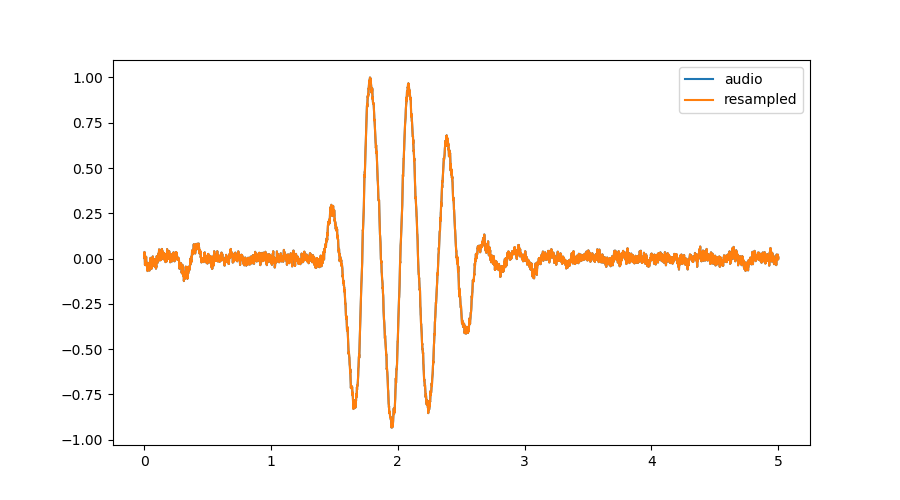

In [137]:
a = resampling_by_points(audio, samplerate, 60000, trans_width=50,
                         method='interp1d', lp_method='fir', fir_method='kaiser', 
                         gpass=1, gstop=80, correct_by_gd=True, gd_padding='periodic',
                         plot_filter=False, normalize=True)
print(len(audio))
print(len(a))
x_audio = np.linspace(0,5,len(audio))
x_res = np.linspace(0,5,len(a))

norm_audio = audio/max(abs(audio))

%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(x_audio, norm_audio, label='audio')
plt.plot(x_res, a, label='resampled')
plt.legend()
plt.show()

2000
4955
225


<IPython.core.display.Javascript object>


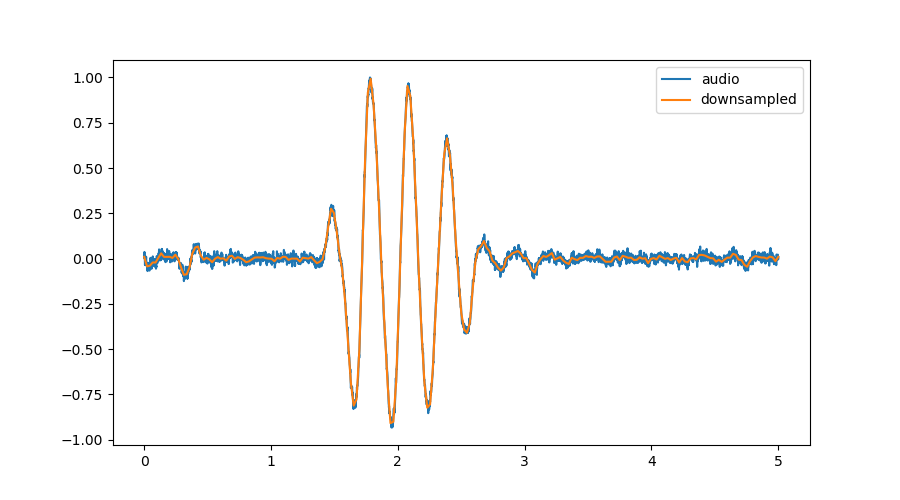

In [146]:
new_rate, dwns_signal = downsampling_signal(norm_audio, samplerate, freq_pass=950, freq_stop=1000, 
                                              method='lowpass', lp_method='fir',
                                              resample_method='interp1d',
                                              fir_method='kaiser', gpass=1, gstop=80,
                                              correct_by_gd=True, gd_padding='periodic',
                                              plot_filter=False, normalize=True)

print(new_rate)
print(len(audio))
print(len(dwns_signal))

x_audio = np.linspace(0, 5, len(audio))
x_res = np.linspace(0, 5, len(dwns_signal))

norm_audio = audio/max(abs(audio))

%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(x_audio, norm_audio, label='audio')
plt.plot(x_res, dwns_signal, label='downsampled')
plt.legend()
plt.show()

# Probar nuevo downsampling y upsampling

In [149]:
filename = '2-S2-normal__201101070538'
audio, samplerate = sf.read(f'db_heart/Heart_segments/{filename}.wav')

norm_audio = audio/max(abs(audio))

In [180]:
resample_method = 'resample_poly'

new_rate, dwns_signal = downsampling_signal(norm_audio, samplerate, freq_pass=950, freq_stop=1000, 
                                              method='lowpass', lp_method='fir',
                                              resample_method=resample_method,
                                              fir_method='kaiser', gpass=1, gstop=80,
                                              correct_by_gd=True, gd_padding='periodic',
                                              plot_filter=False, normalize=True)

audio_out = upsampling_signal(dwns_signal, new_rate, samplerate,
                              N_desired=len(norm_audio), method='lowpass',
                              trans_width=50, lp_method='fir',
                              resample_method=resample_method,
                              fir_method='kaiser', gpass=1, gstop=80, 
                              correct_by_gd=True, gd_padding='periodic',
                              plot_filter=False, plot_signals=False,
                              normalize=True)

print(len(norm_audio))
print(len(audio_out))

4955
4955


<IPython.core.display.Javascript object>


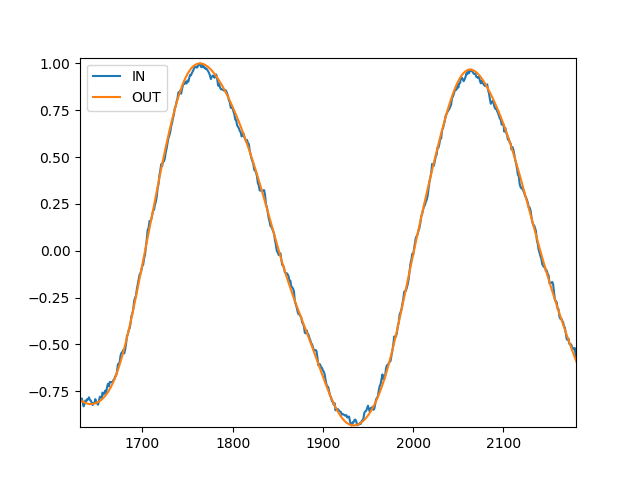

In [181]:
%matplotlib notebook
plt.plot(norm_audio, label='IN')
plt.plot(audio_out, label='OUT')
plt.legend()
plt.show()